In [1]:
!pip install transformers
!pip install sentence-transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm, trange
import torch
from torch.optim import AdamW
from torch import device
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import os
import pandas as pd
import numpy as np
import re 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import porter
import random

print("IMPORTED LIBRARIES SUCCESSFULLY")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=77fe6428607cd710ff5ae2d510fb000938221fef7ca3108f8daadc9f42033ca2
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
IMPORTED LIBRARIES SUCCESSFULLY


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/AITA/data')
  nta = pd.read_json("NTA_Dataset.jsonl", lines=True)
  yta = pd.read_json("YTA_Dataset.jsonl", lines=True)
  nta['label'] = 0
  yta['label'] = 1
except:
  print("Could not import drive from google colab")

Mounted at /content/drive


In [3]:
def preprocess(data):
  # in: 2d table with prompts and resolution
  # out: tidied data
  # ends with 5 hashtags
  # remove capitalisation?
  # 
  data['completion'] = data['completion'].str.lower()
  data['completion'] = data['completion'].str.replace(r'#', '', regex=True)
  #data['completion'] = data['completion'].str.replace(r'[N,n,Y,y][T,t][A,a]', '', regex=True)
  # This currently replaces *all* occurences of "nta" and "yta". "Contact"->"Coct"
  data['completion'] = data['completion'].str.remove_prefix(r'[NnYy][Tt][Aa]', 1, regex=True)
  data['completion'] = data['completion'].str.replace(r'\s+', ' ', regex=True)
  return data

def correct_labels(data):
  data.loc[(data["completion"].str.lower()).str.startswith(' definitely nta'), 'label'] = 0
  return data

yta = correct_labels(yta)
data = pd.concat([nta,yta,yta])
data.drop(["completion"],axis=1,inplace=True)

In [4]:
max_len = 256
prompts = data.prompt.values
labes = data.label.values
prompt_ids = []
masks = []
batch_size = 16

In [5]:
# create tokenizer
t = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

for i in trange(len(prompts)):
  prompt = prompts[i]
  e = t.encode(prompt, add_special_tokens = True, truncation=True, max_length=max_len)
  prompt_ids.append(e)

prompt_ids = pad_sequences(prompt_ids, maxlen=max_len, padding="post")

for p in prompt_ids:
  masks.append([int(id > 0 ) for id in p])

100%|██████████| 10238/10238 [01:00<00:00, 170.30it/s]


In [6]:
tr_in, te_in, tr_lab, te_lab = train_test_split(prompt_ids, labes, test_size = .2)
tr_masks, te_masks, _, _ = train_test_split(masks, labes, test_size=.2)

tr_in = torch.tensor(tr_in)
te_in = torch.tensor(te_in)
tr_lab = torch.tensor(tr_lab)
te_lab = torch.tensor(te_lab)
tr_masks = torch.tensor(tr_masks)
te_masks = torch.tensor(te_masks)

tr_d = TensorDataset(tr_in, tr_masks, tr_lab)
tr_s = RandomSampler(tr_d)
tr_dl = DataLoader(tr_d, sampler = tr_s, batch_size = batch_size)
te_d = TensorDataset(te_in, te_masks, te_lab)
te_s = RandomSampler(te_d)
te_dl = DataLoader(te_d, sampler = te_s, batch_size = batch_size)

In [7]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)
optimzier = AdamW(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
try:
  device = torch.device("cuda")
  model.to(device)
except:
  device = torch.device("cpu")
  model.to(device)

In [13]:
os.chdir('/content/drive/MyDrive/AITA/models')
chp = torch.load("pytorch_model2.bin")
model.load_state_dict(chp)

<All keys matched successfully>

In [14]:
def b_metrics(preds, labels):
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])
  tn = sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])
  fp = sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])
  fn = sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

model.eval()

val_acc = []
val_p = []
val_recall = []
val_spec = []

for batch in te_dl:
  with torch.device('cuda') as device:
    b = tuple(t.to(device) for t in batch)
    b_id = batch[0].to(device)
    b_m = batch[1].to(device)
    b_lab = batch[2].to(device)
    with torch.no_grad():
      eval_out = model(b_id, token_type_ids=None, attention_mask=b_m)
      logits = eval_out.logits.detach().cpu().numpy()
      label_ids = b_lab.to('cpu').numpy()
      b_acc, b_prec, b_recall, b_spec = b_metrics(logits, label_ids)
      val_acc.append(b_acc)
      if b_prec != 'nan': val_p.append(b_prec)
      if b_recall != 'nan': val_recall.append(b_recall)
      if b_spec != 'nan': val_spec.append(b_spec)


print('\t - Testing Accuracy: {:.4f}'.format(sum(val_acc)/len(val_acc)))
prec = sum(val_p)/len(val_p)
rec = sum(val_recall)/len(val_recall)
print('\t - Testing Precision: {:.4f}'.format(prec) if len(val_p)>0 else '\t - Validation Precision: NaN')
print('\t - Testing Recall: {:.4f}'.format(rec) if len(val_recall)>0 else '\t - Validation Recall: NaN')
print('\t - Testing F1: {:.4f}\n'.format((2*prec*rec)/(prec+rec)) if len(val_recall)>0 and len(val_p)>0 else '\t - Validation Specificity: NaN')

	 - Testing Accuracy: 0.9668
	 - Testing Precision: 0.9449
	 - Testing Recall: 0.9921
	 - Testing F1: 0.9679



In [15]:
stops = stopwords.words("english")
lemmatizer = nltk.WordNetLemmatizer()
prompts = data.prompt.values

def process_prompt(sentence):
  sent = re.sub('[^\w\s]', '', sentence.lower().strip()).split()
  stemmer = porter.PorterStemmer()
  t_sent = [w for w in sent if w not in stops]
  t_sent = [stemmer.stem(w) for w in t_sent]
  t_sent = [lemmatizer.lemmatize(w) for w in t_sent]

  return " ".join(t_sent)

prompts_clean = [process_prompt(p) for p in prompts]
categories = ["irresponsiblity","entitlement","stupidity","bigotry","miscommunication","trauma","betrayal","dangerousness","obsession","pride","insecurity","rudeness"]

In [16]:
m = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = m.encode(prompts_clean)
cats_emb = m.encode(categories)

In [17]:
def calc_sliding_cosine_similarity(sent, embs, w):
  sims = []
  for i in range(len(sent)-w):
    sims.append(cosine_similarity([m.encode(sent[i:i+w])], embs))
  sims = np.array(sims).T
  sims =np.array([a[0] for a in sims])
  sims_avg = [np.mean(sim) for sim in sims]
  closest = np.argmax(sims_avg)
  return closest

In [18]:
c_dict = {"irresponsiblity": 0,
          "entitlement":0,
          "stupidity":0,
          "bigotry":0,
          "miscommunication":0,
          "trauma":0,
          "betrayal":0,
          "dangerousness":0,
          "obsession":0,
          "pride":0,
          "insecurity":0,
          "rudeness":0}

In [19]:
for j in range(1000):
  i = random.randint(0, len(prompts_clean)-1)
  sentence = prompts_clean[i]
  c_dict[categories[calc_sliding_cosine_similarity(sentence, cats_emb, 15)]] += 1

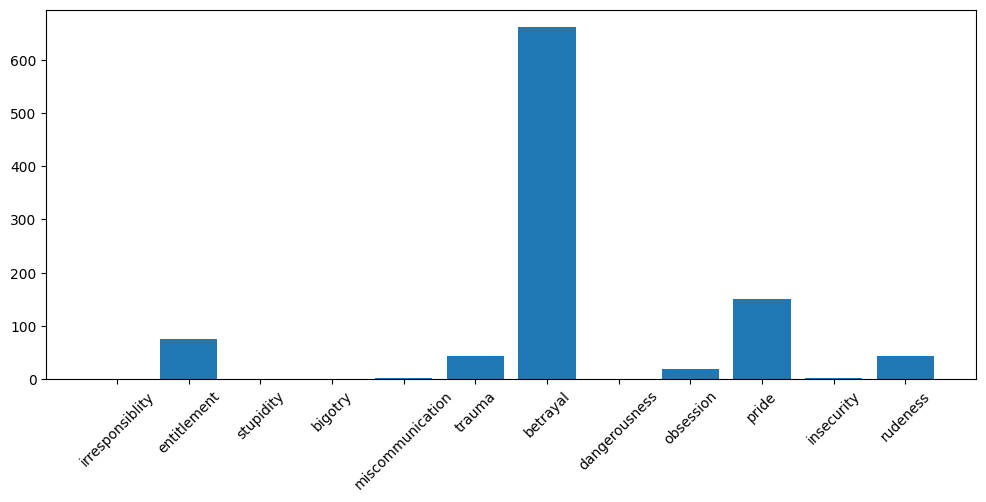

In [22]:
import matplotlib.pyplot as plt
plt.figure().set_figwidth(12)
plt.bar(list(c_dict.keys()), c_dict.values())
plt.xticks(rotation=45)

plt.show()